In [1]:
%%html
<style> table { display: inline-block } </style>

# CAB420 Assigment 2 - Model 4

| Name   | Student Number |
| :---   | :--- |
| Charmi Raval       | N10510702          |
| Leonardo Villamil  | N10411526          |
| Litian Chen        | N9646922           |
| Tace Stewart       | N9654411           |

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import visualkeras

from sklearn.utils import class_weight
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import ResNet50

## Load Data

In [3]:
# Load data
train = pd.read_csv ('Data/training.csv')
validation = pd.read_csv ('Data/validation.csv')
test = pd.read_csv ('Data/testing.csv')

In [4]:
# Split filename, features and label

X_train = train.drop(['filename', 'accent'], axis=1)
path_train = train['filename'].to_numpy()
y_train = train['accent'].to_numpy()

X_val = validation.drop(['filename', 'accent'], axis=1)
path_val = validation['filename'].to_numpy()
y_val = validation['accent'].to_numpy()

X_test = test.drop(['filename', 'accent'], axis=1)
path_test = test['filename'].to_numpy()
y_test = test['accent'].to_numpy()

In [5]:
# Encode strings into class numbers
labels = np.unique(y_train)

encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

In [6]:
# Calculation of class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

for i in range(17):
    print('%s - class %s - weight %s\n' %(labels[i], (str(np.unique(y_train)[i])), str(class_weights[i])))

african - class 0 - weight 3.7325975166185876

australia - class 1 - weight 0.9309988842195273

bermuda - class 2 - weight 29.67098703888335

canada - class 3 - weight 1.010343344725347

england - class 4 - weight 0.31900411260902345

hongkong - class 5 - weight 13.43162328870167

indian - class 6 - weight 0.7413558308698973

ireland - class 7 - weight 5.088919288645691

malaysia - class 8 - weight 15.962810656177364

newzealand - class 9 - weight 4.769995191537105

other - class 10 - weight 1.1126620139581256

philippines - class 11 - weight 12.156862745098039

scotland - class 12 - weight 4.539122476994255

singapore - class 13 - weight 35.48489666136725

southatlandtic - class 14 - weight 71.941982272361

us - class 15 - weight 0.12046160758497954

wales - class 16 - weight 15.914438502673796

/home/leonardo/CAB420-env/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16], y=[15  4 15 ... 15  3  6

Let's load the images and reshaped to 224 X 224

In [7]:
# Path to your 'en' folder as downloaded from https://commonvoice.mozilla.org/en/datasets 
path = '/home/leonardo/Downloads/en/'

dim = (224, 224)

# Load image file
def load_image(filename, dim):
    I = cv2.cvtColor(cv2.imread(path + 'spectrograms/' + filename +'.png'), cv2.COLOR_BGR2RGB)/255
    I = cv2.resize(I, dim)
    return I

X_train_I = []
X_val_I = []
X_test_I = []

counter = 0;
total = len(path_train)
print('\nLoading Training data... ')
for filename in path_train:
    counter += 1
    I = load_image(filename, dim)
    X_train_I.append(I)
    print('Loading Training data... %d/%d' %(counter, total))
    if counter == 10:
        break
print('Loading Training data completed %d/%d' %(counter, total))

counter = 0;
total = len(path_val)
print('\nLoading Validation data... ')
for filename in path_val:
    counter += 1
    I = load_image(filename, dim)
    X_val_I.append(I)
    print('Loading Validation data... %d/%d' %(counter, total))
    if counter == 10:
        break
print('Loading Validation data completed %d/%d' %(counter, total))

counter = 0;
total = len(path_test)
print('\nLoading Testing data... ', end='')
for filename in path_test:
    counter += 1
    I = load_image(filename, dim)
    X_test_I.append(I)
    print('Loading Testing data... %d/%d' %(counter, total))
    if counter == 10:
        break
print('Loading Testing data completed %d/%d' %(counter, total))

X_train_I = np.asarray(X_train_I)
X_val_I = np.asarray(X_val_I)
X_test_I = np.asarray(X_test_I)


Loading Training data... 
Loading Training data... 1/89280
Loading Training data... 2/89280
Loading Training data... 3/89280
Loading Training data... 4/89280
Loading Training data... 5/89280
Loading Training data... 6/89280
Loading Training data... 7/89280
Loading Training data... 8/89280
Loading Training data... 9/89280
Loading Training data... 10/89280
Loading Training data completed 10/89280

Loading Validation data... 
Loading Validation data... 1/29759
Loading Validation data... 2/29759
Loading Validation data... 3/29759
Loading Validation data... 4/29759
Loading Validation data... 5/29759
Loading Validation data... 6/29759
Loading Validation data... 7/29759
Loading Validation data... 8/29759
Loading Validation data... 9/29759
Loading Validation data... 10/29759
Loading Validation data completed 10/29759

Loading Testing data... Loading Testing data... 1/29759
Loading Testing data... 2/29759
Loading Testing data... 3/29759
Loading Testing data... 4/29759
Loading Testing data... 5

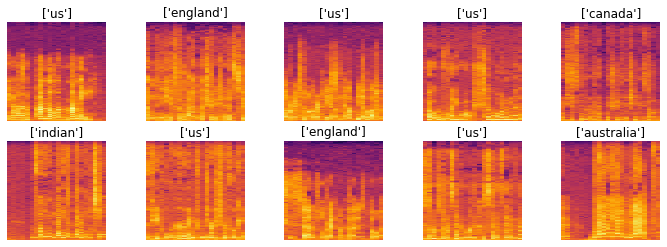

In [8]:
# Show first 10 images in the training set
fig = plt.figure(figsize=[12,4])
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(X_train_I[i,:,:,:])
    ax.set_title(encoder.inverse_transform([y_train[i]]))
    ax.axis("off")

Because the large number of file in the database and due to computational limits, we can not load the whole dataset as a single variable. Instead we will use the ImageGenerator class provided by keras as follow:

In [9]:
datagen = ImageDataGenerator()

# load and iterate training dataset
train_it = datagen.flow_from_directory('Data/spectograms/train/',
                                       target_size=(224, 224),
                                       classes=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'],
                                       class_mode='categorical', batch_size=64, seed=1)

# load and iterate validation dataset
val_it = datagen.flow_from_directory('Data/spectograms/validation/',
                                     target_size=(224, 224),
                                     classes=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'], 
                                     class_mode='categorical', batch_size=64, seed=1)

# load and iterate test dataset
test_it = datagen.flow_from_directory('Data/spectograms/test/',
                                      target_size=(224, 224),
                                      classes=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'],
                                      class_mode='categorical', batch_size=1,
                                      shuffle=False)

Found 89280 images belonging to 17 classes.
Found 29759 images belonging to 17 classes.
Found 29759 images belonging to 17 classes.


## First CNN Model

In [14]:
def eval_model(prediction, test_it, labels, history):
    test_it.reset()
    print('Classification Report\n')
    print(classification_report(test_it.classes, prediction))

    test_it.reset()
    print('Confusion Matrix')
    cm = confusion_matrix(test_it.classes, prediction, normalize='true')
    fig = plt.figure(figsize=[20, 20])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=labels)
    c.plot(ax = ax);

    fig = plt.figure(figsize=[12, 4])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();

    fig = plt.figure(figsize=[12, 4])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['precision'], label="Training Precision")
    ax.plot(history.history['val_precision'], label="Validation Precision")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['recall'], label="Training Recall")
    ax.plot(history.history['val_recall'], label="Validation Recall")
    ax.legend();

Model: "cnn_model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 8)       608       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 224, 8)       1608      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 16)        1168      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 16)        0

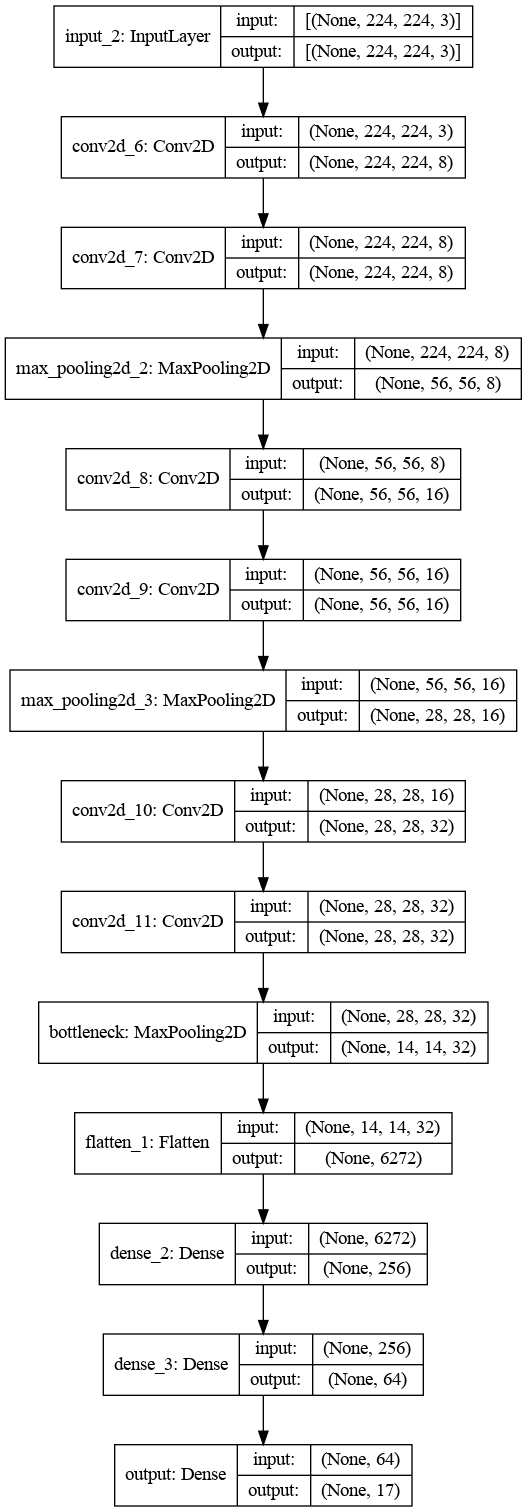

In [11]:
input_img = Input(shape=(224, 224, 3))

conv1 = Conv2D(8, (5, 5), activation='relu', padding='same')(input_img)
conv1 = Conv2D(8, (5, 5), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((4, 4), padding='same')(conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2), padding='same')(conv3)

flatten = Flatten()(pool3)

# gender Output
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(17, activation='softmax', name='output')(dense2)

cnn_model1 = Model(input_img, output, name='cnn_model1')

cnn_model1.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   loss_weights=class_weights,
                   metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

print(cnn_model1.summary())

plot_model(cnn_model1, show_shapes=True)

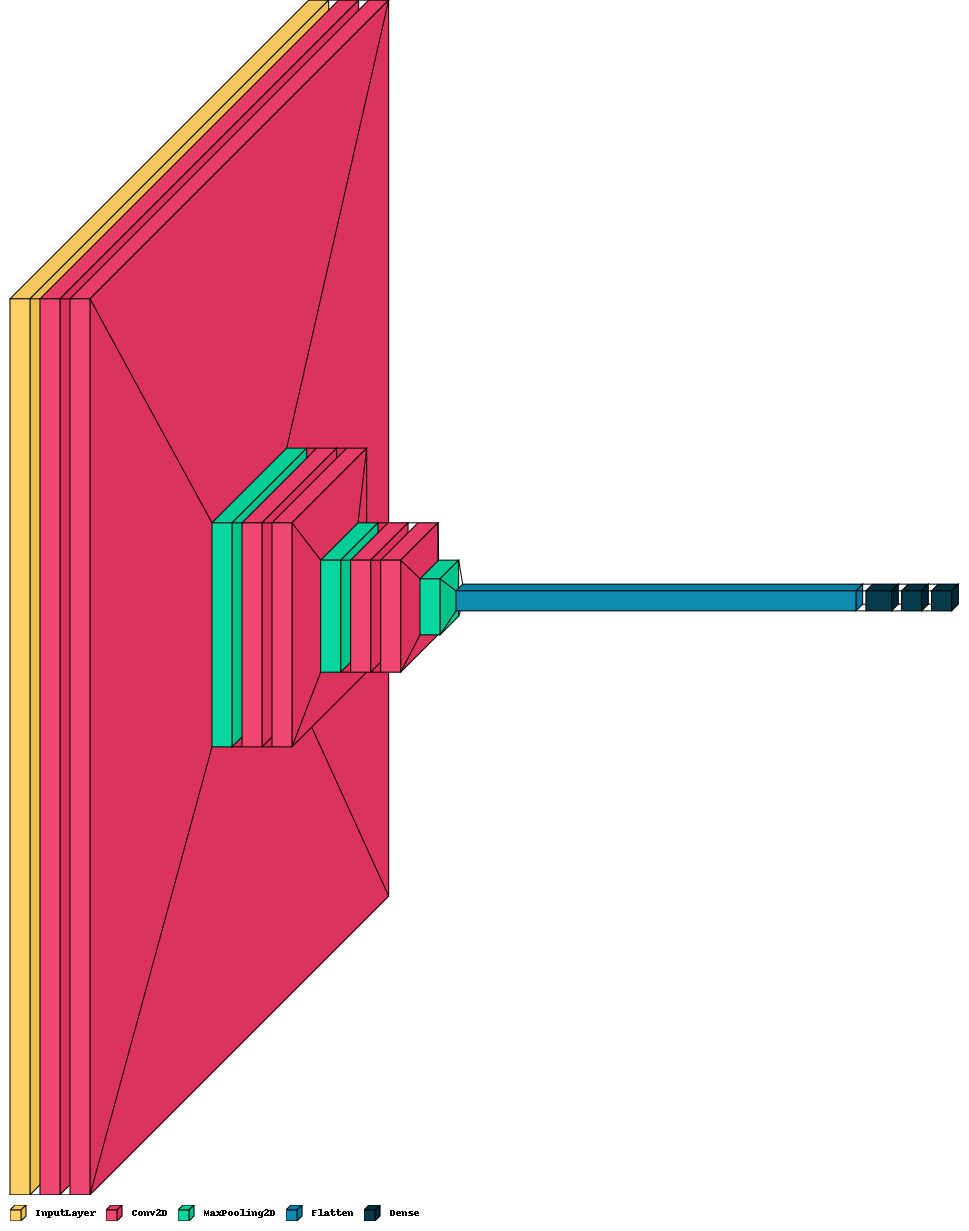

In [12]:
visualkeras.layered_view(cnn_model1, legend=True)

In [13]:
load_model = True

if load_model:
    cnn_model1 = load_model('Models/cnn_model1')
else:
    history = cnn_model1.fit(train_it,
                            steps_per_epoch=1395,
                            epochs=10,
                            validation_data=val_it,
                            validation_steps=465)

    # Save model
    cnn_model1.save('Models/cnn_model1')

Epoch 1/10
1395/1395 [==============================] - 4246s 3s/step - loss: 23.2827 - accuracy: 0.4816 - precision: 0.5077 - recall: 0.2130 - val_loss: 21.0829 - val_accuracy: 0.5040 - val_precision: 0.5223 - val_recall: 0.4620
Epoch 2/10
1395/1395 [==============================] - 4199s 3s/step - loss: 20.1100 - accuracy: 0.5150 - precision: 0.5848 - recall: 0.3011 - val_loss: 19.2753 - val_accuracy: 0.5303 - val_precision: 0.6339 - val_recall: 0.2829
Epoch 3/10
1395/1395 [==============================] - 4232s 3s/step - loss: 18.7290 - accuracy: 0.5387 - precision: 0.6208 - recall: 0.3455 - val_loss: 18.3647 - val_accuracy: 0.5470 - val_precision: 0.6536 - val_recall: 0.3319
Epoch 4/10
1395/1395 [==============================] - 4252s 3s/step - loss: 17.2859 - accuracy: 0.5686 - precision: 0.6607 - recall: 0.3954 - val_loss: 17.5044 - val_accuracy: 0.5697 - val_precision: 0.6614 - val_recall: 0.3885
Epoch 5/10
1395/1395 [==============================] - 4227s 3s/step - loss: 15

29759/29759 [==============================] - 332s 11ms/step - loss: 26.7107 - accuracy: 0.5109 - precision: 0.5446 - recall: 0.4643
Classification Report

              precision    recall  f1-score   support

           0       0.22      0.17      0.19       465
           1       0.33      0.27      0.30      1817
           2       0.00      0.00      0.00        53
           3       0.24      0.16      0.19      1682
           4       0.41      0.48      0.44      5455
           5       0.59      0.34      0.43       133
           6       0.41      0.46      0.43      2323
           7       0.32      0.13      0.19       357
           8       0.32      0.12      0.18        97
           9       0.33      0.09      0.14       384
          10       0.45      0.45      0.45      1632
          11       0.12      0.05      0.07       135
          12       0.47      0.13      0.20       386
          13       0.00      0.00      0.00        67
          14       0.29      0.0

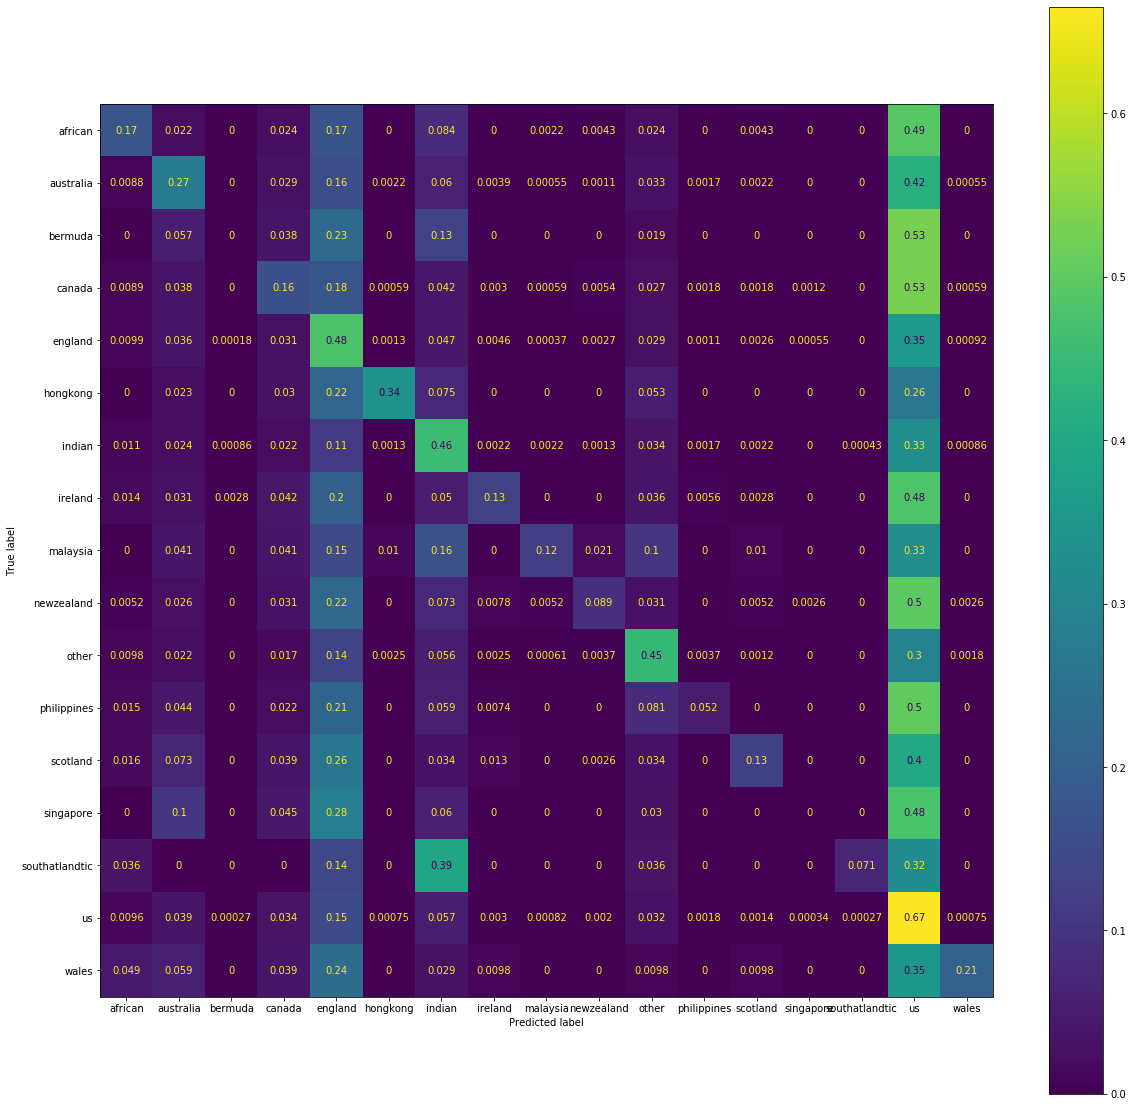

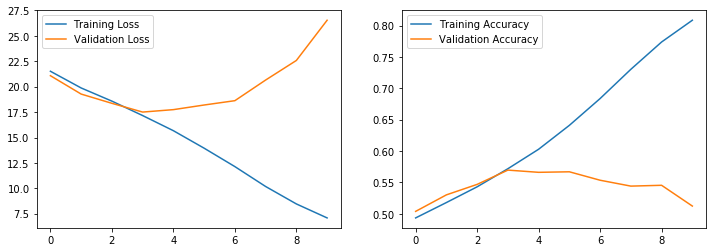

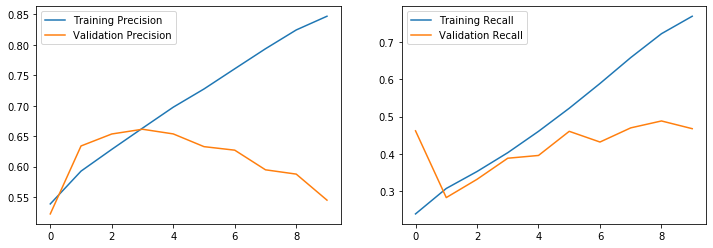

In [48]:
test_it.reset()
test_scores = cnn_model1.evaluate(test_it, steps=29759)

test_it.reset()
prediction = cnn_model1.predict(test_it, steps=29759)
prediction = np.argmax(prediction, axis=1)

eval_model(prediction, test_it, labels, history)

## Second CNN Model

Model: "cnn_model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 8)       608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 8)       1608      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 8)       32        
_________________________________________________________________
activation (Activation)      (None, 224, 224, 8)       0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 224, 224, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 8)         0

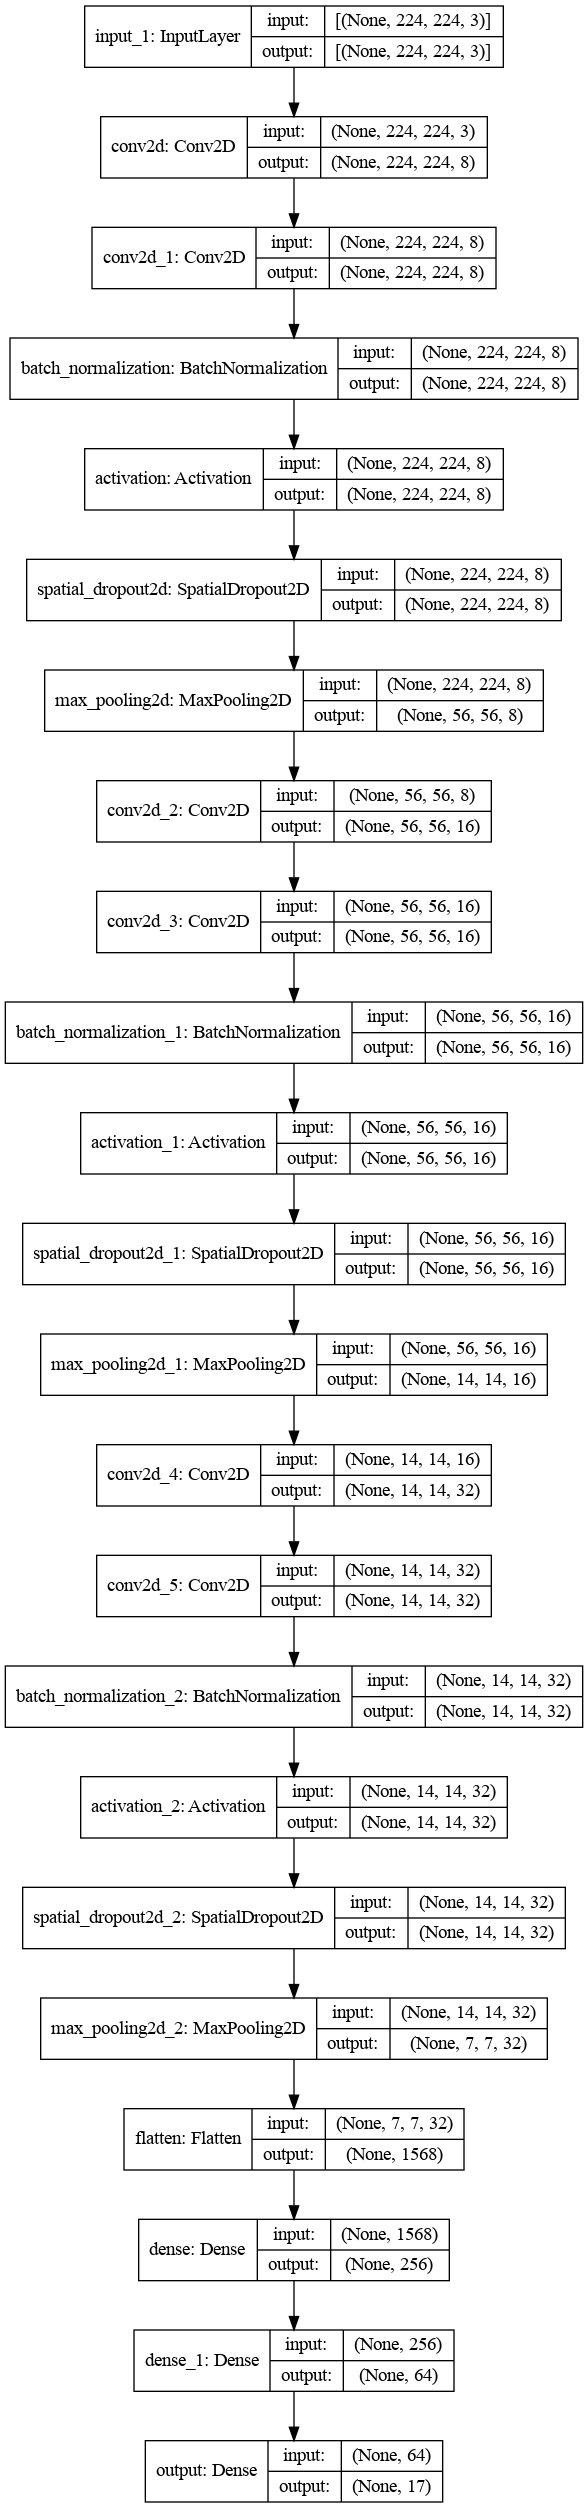

In [10]:
input_img = Input(shape=(224, 224, 3))

conv1 = Conv2D(8, (5, 5), activation='relu', padding='same')(input_img)
conv1 = Conv2D(8, (5, 5), activation=None, padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = SpatialDropout2D(0.2)(conv1)
pool1 = MaxPooling2D((4, 4), padding='same')(conv1)

conv2 = Conv2D(16, (5, 5), activation='relu', padding='same')(pool1)
conv2 = Conv2D(16, (5, 5), activation=None, padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = SpatialDropout2D(0.2)(conv2)
pool2 = MaxPooling2D((4, 4), padding='same')(conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(32, (3, 3), activation=None, padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
conv3 = SpatialDropout2D(0.2)(conv3)
pool3 = MaxPooling2D((2, 2), padding='same')(conv3)

flatten = Flatten()(pool3)

# gender Output
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(17, activation='softmax', name='output')(dense2)

cnn_model2 = Model(input_img, output, name='cnn_model2')

cnn_model2.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   loss_weights=class_weights,
                   metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

print(cnn_model2.summary())

plot_model(cnn_model2, show_shapes=True)

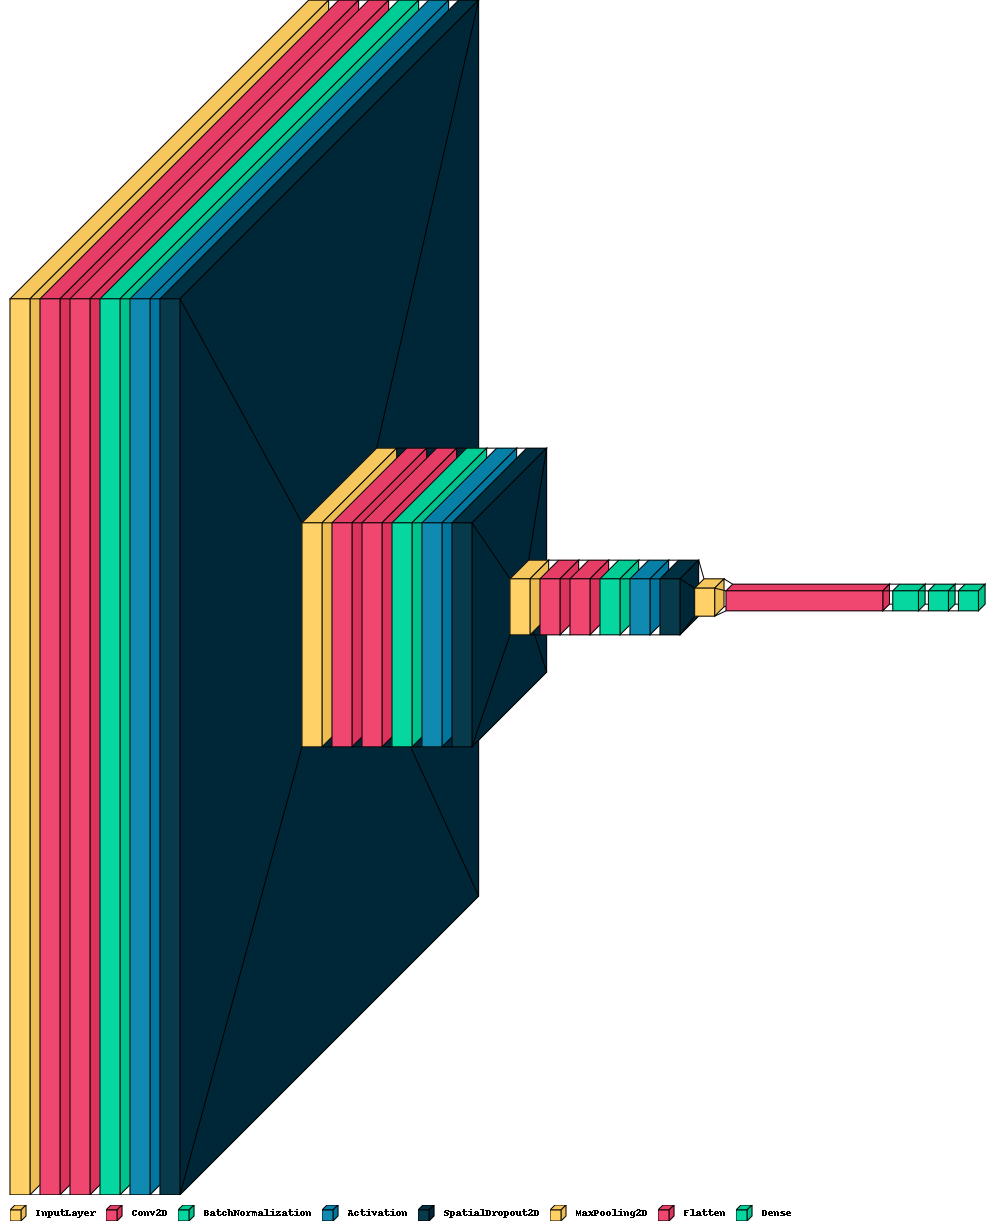

In [11]:
visualkeras.layered_view(cnn_model2, legend=True)

In [12]:
load_model = True

if load_model:
    cnn_model2 = load_model('Models/cnn_model2')
else:
    history = cnn_model2.fit(train_it,
                            steps_per_epoch=1395,
                            epochs=10,
                            validation_data=val_it,
                            validation_steps=465)

    # Save model
    cnn_model2.save('Models/cnn_model2')

Epoch 1/10
1395/1395 [==============================] - 5394s 4s/step - loss: 22.1064 - accuracy: 0.4823 - precision: 0.5128 - recall: 0.2069 - val_loss: 21.0582 - val_accuracy: 0.4918 - val_precision: 0.5653 - val_recall: 0.2323
Epoch 2/10
1395/1395 [==============================] - 5487s 4s/step - loss: 20.5446 - accuracy: 0.5023 - precision: 0.5642 - recall: 0.2552 - val_loss: 20.5417 - val_accuracy: 0.4963 - val_precision: 0.6424 - val_recall: 0.1494
Epoch 3/10
1395/1395 [==============================] - 5442s 4s/step - loss: 19.8233 - accuracy: 0.5148 - precision: 0.5976 - recall: 0.2880 - val_loss: 19.3320 - val_accuracy: 0.5268 - val_precision: 0.6540 - val_recall: 0.2614
Epoch 4/10
1395/1395 [==============================] - 5478s 4s/step - loss: 18.8847 - accuracy: 0.5349 - precision: 0.6281 - recall: 0.3263 - val_loss: 18.2172 - val_accuracy: 0.5473 - val_precision: 0.6653 - val_recall: 0.3353
Epoch 5/10
1395/1395 [==============================] - 5658s 4s/step - loss: 18

29759/29759 [==============================] - 719s 24ms/step - loss: 15.7750 - accuracy: 0.6068 - precision: 0.7107 - recall: 0.4683
Classification Report

/home/leonardo/CAB420-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leonardo/CAB420-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leonardo/CAB420-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

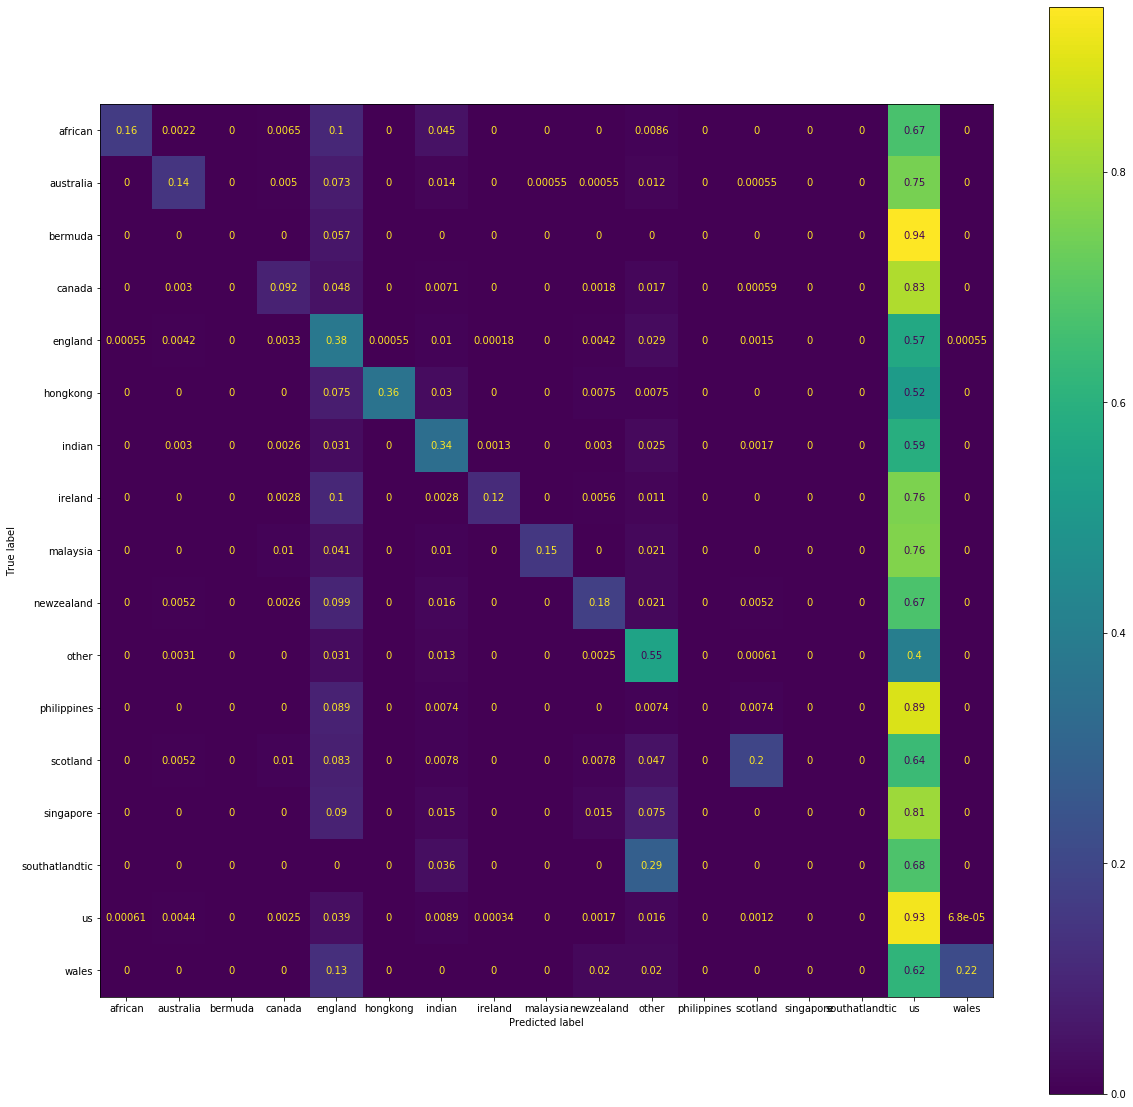

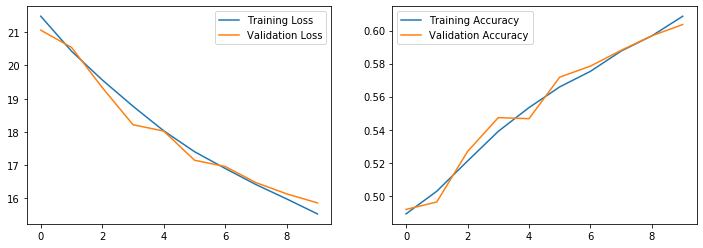

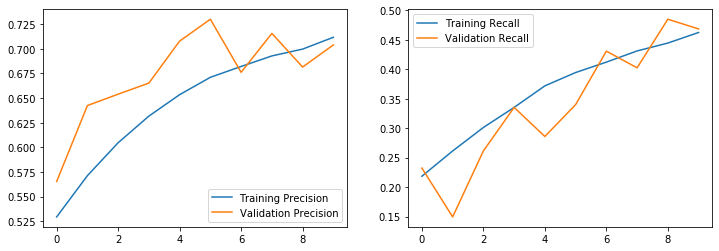

In [15]:
test_it.reset()
test_scores = cnn_model2.evaluate(test_it, steps=29759)

test_it.reset()
prediction = cnn_model2.predict(test_it, steps=29759)
prediction = np.argmax(prediction, axis=1)

eval_model(prediction, test_it, labels, history)

## Fine-tuning 

]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]        

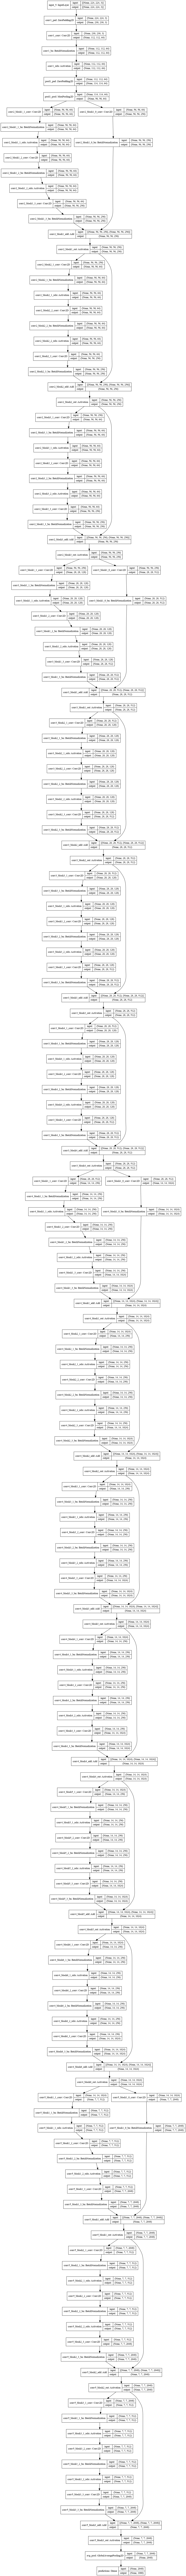

In [30]:
ResNet = ResNet50()
print(ResNet.summary())
plot_model(ResNet, show_shapes=True)

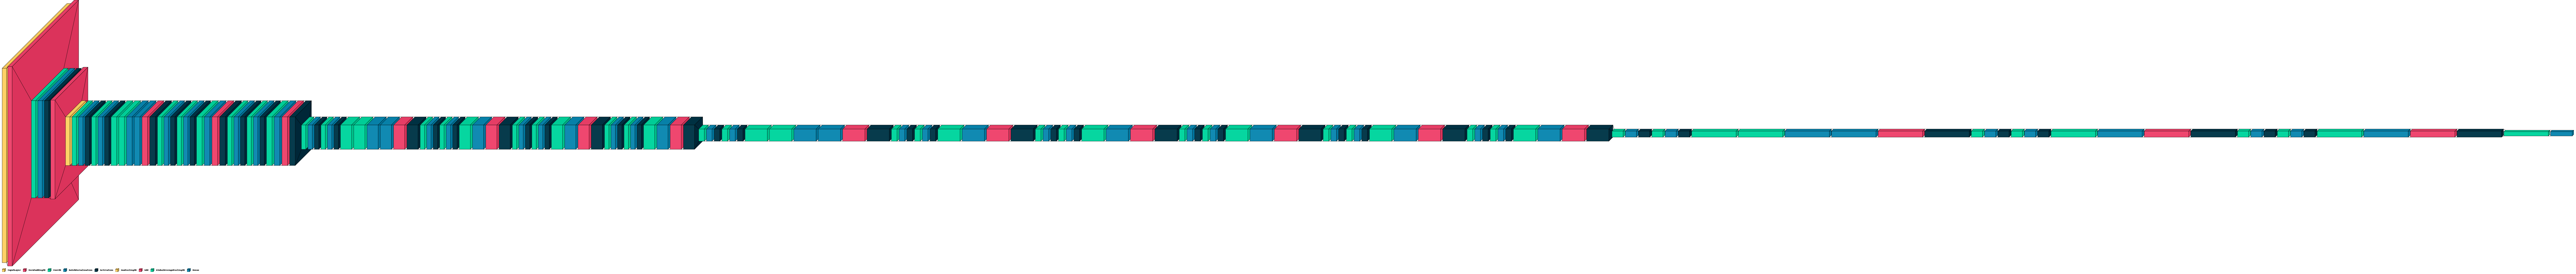

In [31]:
visualkeras.layered_view(ResNet, legend=True)

In [32]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
print(baseModel.summary())

0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]      

In [35]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(17, activation="softmax")(headModel)

cnn_model3 = Model(inputs=baseModel.input, outputs=headModel, name='cnn_model3')
print(cnn_model3.summary())

[0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 14, 14, 1024) 525312      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_0_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_0_conv[0][0]       

In [36]:
# Freeze the base model layers
for layer in baseModel.layers:
	layer.trainable = False

In [37]:
cnn_model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   loss_weights=class_weights,
                   metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

In [38]:
load_model = False

if load_model:
    cnn_model3 = load_model('Models/cnn_model3')
else:
    history = cnn_model3.fit(train_it,
                            steps_per_epoch=1395,
                            epochs=10,
                            validation_data=val_it,
                            validation_steps=465)

    # Save model
    cnn_model3.save('Models/cnn_model3')

Epoch 1/10
1395/1395 [==============================] - 9398s 7s/step - loss: 24.0898 - accuracy: 0.4514 - precision: 0.4927 - recall: 0.1980 - val_loss: 20.9247 - val_accuracy: 0.4906 - val_precision: 0.5366 - val_recall: 0.3715
Epoch 2/10
1395/1395 [==============================] - 9214s 7s/step - loss: 21.3016 - accuracy: 0.4955 - precision: 0.5484 - recall: 0.2317 - val_loss: 20.5100 - val_accuracy: 0.5028 - val_precision: 0.5773 - val_recall: 0.2729
Epoch 3/10
1395/1395 [==============================] - 9237s 7s/step - loss: 20.9328 - accuracy: 0.4993 - precision: 0.5598 - recall: 0.2371 - val_loss: 20.2993 - val_accuracy: 0.5061 - val_precision: 0.6059 - val_recall: 0.2348
Epoch 4/10
1395/1395 [==============================] - 9309s 7s/step - loss: 20.6353 - accuracy: 0.5031 - precision: 0.5665 - recall: 0.2473 - val_loss: 20.1976 - val_accuracy: 0.5067 - val_precision: 0.5694 - val_recall: 0.3575
Epoch 5/10
1395/1395 [==============================] - 10288s 7s/step - loss: 2

29759/29759 [==============================] - 3522s 118ms/step - loss: 19.4893 - accuracy: 0.5265 - precision: 0.6435 - recall: 0.2463
Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       465
           1       0.74      0.05      0.10      1817
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00      1682
           4       0.43      0.20      0.27      5455
           5       0.00      0.00      0.00       133
           6       0.63      0.21      0.32      2323
           7       0.00      0.00      0.00       357
           8       0.00      0.00      0.00        97
           9       0.00      0.00      0.00       384
          10       0.80      0.14      0.24      1632
          11       0.00      0.00      0.00       135
          12       0.00      0.00      0.00       386
          13       0.00      0.00      0.00        67
          14       0.00      0

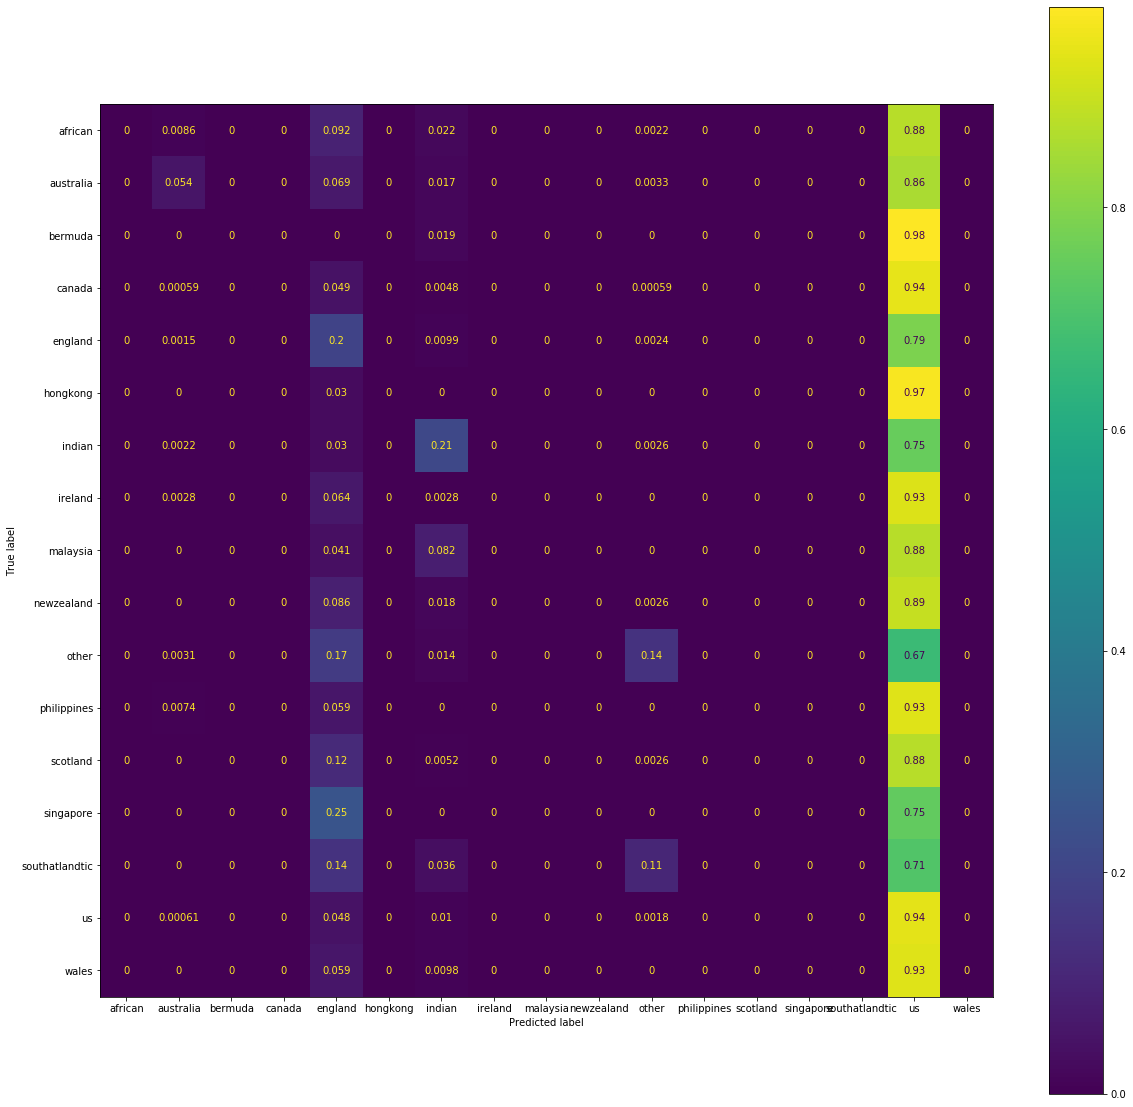

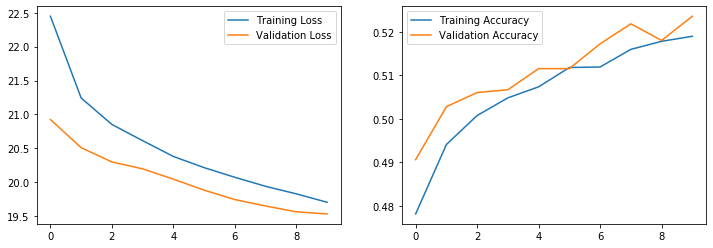

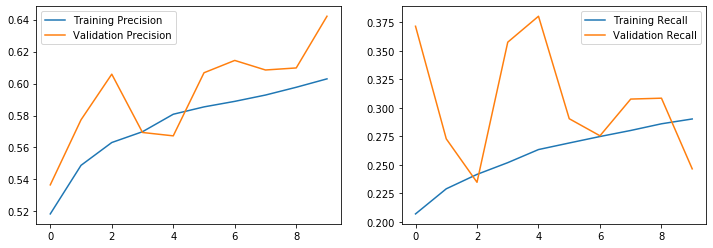

In [39]:
test_it.reset()
test_scores = cnn_model3.evaluate(test_it, steps=29759)

test_it.reset()
prediction = cnn_model3.predict(test_it, steps=29759)
prediction = np.argmax(prediction, axis=1)

eval_model(prediction, test_it, labels, history)